In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

In [10]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,4.0,10.394929,7.244125,0.016991,2.0,1.480796,17.323687,6.789408,1.046972,9.521707,69.319600,22.941639
1,0,android_turns.csv,4.0,9.401910,7.497719,0.016103,2.0,1.693853,6.197542,10.101060,1.153392,11.245602,84.723694,20.737572
2,0,android_turns.csv,5.0,11.290954,4.244563,0.008359,2.0,21.173470,11.229438,9.081976,5.708309,24.616348,105.462135,18.996666
3,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1.0,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
4,0,android_turns.csv,5.0,8.986107,5.990321,0.013587,0.0,19.387754,2.729067,20.937756,1.197121,2.787075,16.806042,91.713660


In [11]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_left = df_v3[df_v3['eventType'] == 4]
sub_df_left = sub_df_left.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

In [12]:
sub_df_left.columns.tolist()

['eventDurationSeconds',
 'eventMilesDriven',
 'eventStartSpeed',
 'eventEndSpeed',
 'memsMedianHorizontalNorm',
 'gyro_angular_change_per_second',
 'gyroAngleChange',
 'mems_radius']

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
scaler =StandardScaler()

X_features = sub_df_left
features = scaler.fit_transform(X_features)
scaled_df = pd.DataFrame(features,columns=X_features.columns)

# Print the scaled data
X = scaled_df.values
scaled_df.head(2)


,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0.736331,-0.309477,0.313634,-1.341506,-0.911557,-0.575256,0.135539,-0.299123
1,0.824479,-0.355795,-0.939736,-0.913205,-0.808508,-0.267585,0.539189,-0.371133


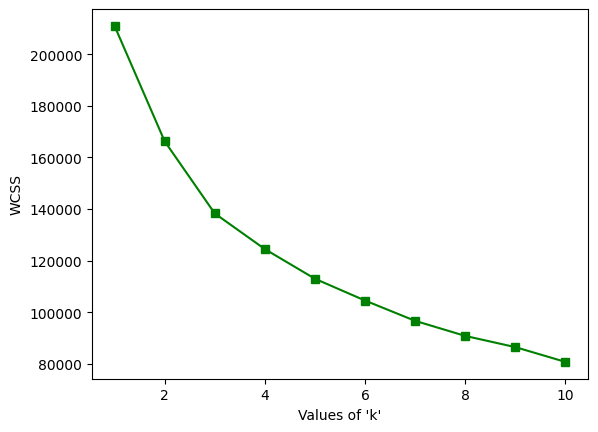

In [14]:
wcss = {} 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss[i] = kmeans.inertia_ 
    
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

In [15]:
results = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)

    results.append((k, sil, ch))

for r in results:
    print(f"k={r[0]} | Silhouette={r[1]:.3f} | CH Score={r[2]:.0f}")

k=2 | Silhouette=0.302 | CH Score=7094
k=3 | Silhouette=0.226 | CH Score=6930
k=4 | Silhouette=0.178 | CH Score=6109
k=5 | Silhouette=0.188 | CH Score=5719
k=6 | Silhouette=0.184 | CH Score=5370
k=7 | Silhouette=0.189 | CH Score=5197
k=8 | Silhouette=0.186 | CH Score=4983
k=9 | Silhouette=0.178 | CH Score=4745


In [16]:
kmeans=KMeans(n_clusters=5)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [17]:
pca=PCA(n_components=3)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2', 'PCA3'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2,PCA3
0,-0.262817,0.351710,-1.435119
1,-0.681353,0.936549,-1.474321
2,-1.119123,0.261199,-0.010895
3,0.185473,0.834395,1.056428
4,-0.359511,1.168559,0.862771


In [18]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[-0.34717216,  0.27332915,  1.3469927 ],
       [-0.3261374 , -1.64235752, -0.61891282],
       [ 1.28127935,  1.55955942, -0.77106003],
       [-1.09359655,  0.69480956, -0.32818696],
       [ 3.43463429, -0.93013316,  0.56791752]])

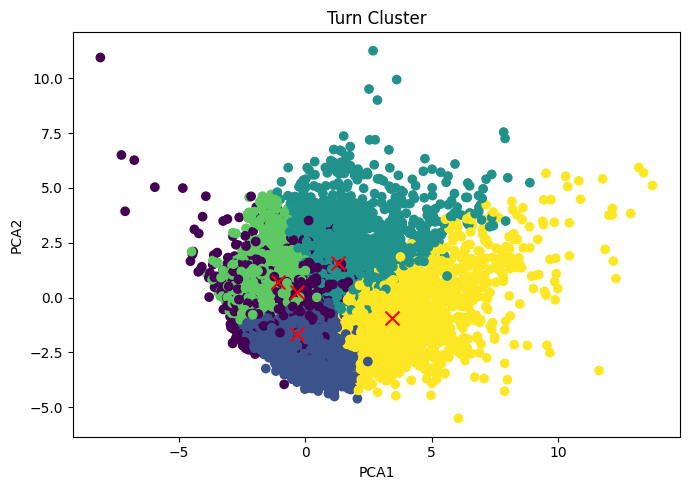

In [19]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [20]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4
eventDurationSeconds,4.283704,2.970500,9.541799,5.044097,6.644623
eventMilesDriven,0.020105,0.013726,0.041664,0.014973,0.052696
eventStartSpeed,16.399401,13.708058,14.034770,8.731736,32.068005
eventEndSpeed,18.830245,15.417245,18.141943,12.312868,32.225124
memsMedianHorizontalNorm,3.098460,1.632384,1.569803,1.663640,1.913499
gyro_angular_change_per_second,16.932834,7.732568,11.342663,15.724418,7.900564
gyroAngleChange,70.976349,22.167054,106.526764,77.357019,52.088899
mems_radius,22.779451,46.582558,32.815995,14.423740,74.035362


In [21]:
kmeans=KMeans(n_clusters=7)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [22]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-0.262817,0.351710
1,-0.681353,0.936549
2,-1.119123,0.261199
3,0.185473,0.834395
4,-0.359511,1.168559


In [23]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 0.95386456,  1.24904798],
       [-0.91668837, -1.18796307],
       [-1.04307191,  0.91786129],
       [ 5.58389881,  1.6732717 ],
       [ 2.36559038, -1.27265221],
       [-0.50236311,  0.31538697],
       [ 0.57945714, -2.60342778]])

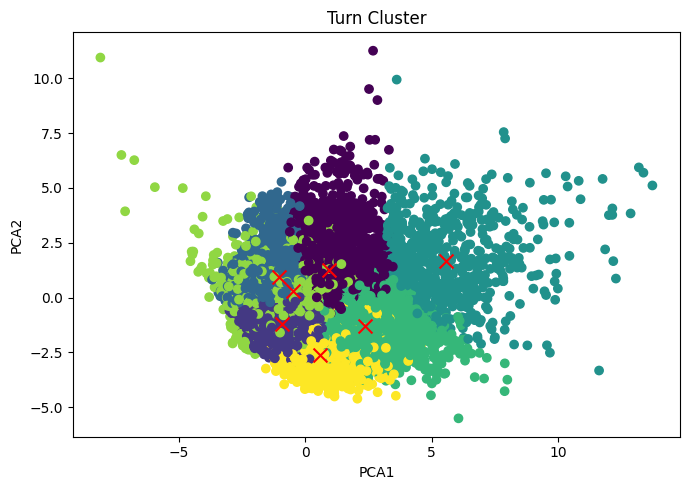

In [24]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [25]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4,5,6
eventDurationSeconds,8.552277,2.744133,5.381991,12.991892,5.174571,4.132291,3.237299
eventMilesDriven,0.036389,0.011441,0.015732,0.103329,0.036508,0.018834,0.015730
eventStartSpeed,13.816315,12.354068,8.435450,31.271445,29.422666,16.205397,13.479867
eventEndSpeed,18.209691,13.901347,12.408513,32.100897,29.740194,18.339580,15.663817
memsMedianHorizontalNorm,1.681092,1.647398,1.701254,1.500429,1.939756,3.235548,1.720333
gyro_angular_change_per_second,11.684608,10.080772,16.067423,7.820775,8.351536,17.706704,4.749407
gyroAngleChange,99.029845,26.027812,84.920590,101.468929,43.333592,71.492968,16.180777
mems_radius,31.256487,25.020683,14.226246,64.602838,62.644709,21.665185,109.466684


In [26]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [27]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-0.262817,0.351710
1,-0.681353,0.936549
2,-1.119123,0.261199
3,0.185473,0.834395
4,-0.359511,1.168559


In [28]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 2.98154847, -0.31543594],
       [-0.46196618,  0.95968552],
       [-0.63523997, -1.36896473]])

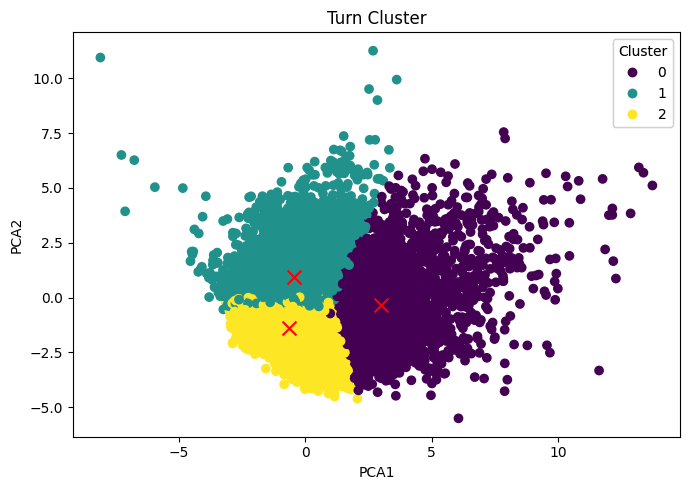

In [29]:
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    reduced_X['PCA1'], reduced_X['PCA2'],
    c=kmeans.labels_, cmap='viridis'
)
plt.scatter(centers[:,0], centers[:,1], marker='x', s=100, c='red')

# Add legend showing which color corresponds to which cluster
legend = plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="upper right"
)
plt.gca().add_artist(legend)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Turn Cluster")
plt.tight_layout()
plt.show()

In [30]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2
eventDurationSeconds,7.554095,5.878709,2.829715
eventMilesDriven,0.051625,0.021283,0.012370
eventStartSpeed,27.512600,11.577454,13.266025
eventEndSpeed,28.617418,15.281157,14.881168
memsMedianHorizontalNorm,1.841925,2.097352,1.883792
gyro_angular_change_per_second,8.493976,15.870935,9.769853
gyroAngleChange,63.913029,88.616447,25.743043
mems_radius,65.061351,18.945853,37.713393


In [31]:
final_labels = kmeans.labels_
features_to_plot = [
    'eventDurationSeconds',
    'gps_radius',
    'bearingAngleChange',
    'bearing_angular_change_per_second',
    'eventStartSpeed',
    'eventEndSpeed',
    'gpsMedianLateralAccel'
]
sub_df_left['cluster'] = final_labels
sub_df_left['cluster'] = sub_df_left['cluster'].astype('category')

df_melted = sub_df_left[['Cluster_Label'] + features_to_plot].melt(
    id_vars=['Cluster_Label'],
    var_name='Feature',
    value_name='Value'
)

sns.set_style("whitegrid")
g = sns.catplot(
    data=df_melted,
    x='Cluster_Label',
    y='Value',
    col='Feature',
    kind='box', 
    col_wrap=3, 
    palette='Set1',
    sharey=False,
    height=4,
    aspect=1.2  
)

g.fig.suptitle('Feature Distributions by Cluster (k=5)', y=1.02, fontsize=16)
g.set_titles("Feature: {col_name}", size=10)
g.set_axis_labels("Cluster Label", "Feature Value (Original Scale)", size=10) 
for ax in g.axes.flat:
    # Check if the title contains the feature you want to scale
    if 'gps_radius' in ax.get_title():
        ax.set_yscale('log')
        # You may want to update the Y-axis label to reflect the log scale
        ax.set_ylabel("Feature Value (Log Scale)", size=10)
    # elif 'bearingAngleChange' in ax.get_title():
    #     # Get the current feature name from the title
    #     feature_key = 'bearingAngleChange'
        
    #     # Set the y-limit based on the value in the custom_ylim dictionary
    #     ax.set_ylim(0, 400) 
        
    #     # Update the Y-axis label to indicate the scale has been capped
    #     ax.set_ylabel(f"Feature Value (Capped at 400)", size=10)

plt.tight_layout()
plt.show()

KeyError: "['Cluster_Label', 'gps_radius', 'bearingAngleChange', 'bearing_angular_change_per_second', 'gpsMedianLateralAccel'] not in index"